In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")


In [2]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
son=son[["Kod","Son.Fyt","Hcm","Yks","Dşk"]]
son.columns=["Hisse","Adj Close","Volume","High","Low"]
son=son.iloc[:-1,:]
son=son.dropna()
hisseler=son["Hisse"].values
hisseler=np.array(hisseler)
for i in range(len(hisseler)):
    hisseler[i]=hisseler[i]+".IS"

In [3]:
df=pd.DataFrame()
for hisse in hisseler:
    hisse_verileri = yf.download(hisse,interval="15m",start="2024-04-04")  # Örnek tarih aralığı
    hisse_kapanis = hisse_verileri[['High','Low','Open','Close','Volume']]
    hisse_kapanis["Hisse"]=hisse
    hisse_kapanis.loc[hisse_kapanis["Close"] > hisse_kapanis["High"], "High"] = hisse_kapanis["Close"]
    hisse_kapanis.loc[hisse_kapanis["Close"] < hisse_kapanis["Low"], "Low"] = hisse_kapanis["Close"]

    df=pd.concat([df,hisse_kapanis],axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,High,Low,Open,Close,Volume,Hisse
Datetime,,,,,,
2024-04-04 09:45:00,28.200001,28.200001,28.200001,28.200001,0,A1CAP.IS
2024-04-04 10:00:00,28.379999,28.139999,28.200001,28.200001,45837,A1CAP.IS
2024-04-04 10:15:00,28.320000,28.059999,28.200001,28.180000,41647,A1CAP.IS
2024-04-04 10:30:00,28.260000,28.120001,28.160000,28.180000,20257,A1CAP.IS
2024-04-04 10:45:00,28.240000,28.139999,28.180000,28.160000,13724,A1CAP.IS
...,...,...,...,...,...,...
2024-05-31 16:45:00,7.980000,7.900000,7.920000,7.960000,235415,ZRGYO.IS
2024-05-31 17:00:00,8.040000,7.940000,7.950000,8.030000,286287,ZRGYO.IS
2024-05-31 17:15:00,8.110000,7.990000,8.020000,8.080000,289909,ZRGYO.IS


In [4]:
df=df.shift(1)

In [5]:
ddata=df.copy()

In [6]:
df["Volume"]=df["Close"]*df["Volume"]
df["Close"]=np.round(df["Close"],2)
df["High"]=np.round(df["High"],2)
df["Low"]=np.round(df["Low"],2)
df["Open"]=np.round(df["Open"],2)
df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']

In [7]:
df["Kademe"] = np.where(df["Adj Close"] < 20, 0.01,
                np.where(df["Adj Close"] < 50, 0.02,
                    np.where(df["Adj Close"] < 100, 0.05,
                        np.where(df["Adj Close"] < 250, 0.1,
                            np.where(df["Adj Close"] < 500, 0.25,
                                np.where(df["Adj Close"] < 1000, 0.5,
                                    np.where(df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )


In [8]:
df["Date"]=pd.to_datetime(df.index)

In [9]:
import math
def yuvarla_asagi(row):
    fiyat = row['Adj Close']
    kadem = row['Kademe']
    return math.floor(fiyat * 1.1 / kadem) * kadem



In [10]:
açılış=df[(df["Date"].dt.minute==45) & (df["Date"].dt.hour==9)]
açılış=açılış.dropna()
açılış["Tavan"]=açılış.apply(yuvarla_asagi, axis=1)
açılış

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Date,Tavan
Datetime,,,,,,,,,
2024-04-05 09:45:00,28.28,28.16,28.18,28.26,4.261099e+06,A1CAP.IS,0.02,2024-04-05 09:45:00,31.08
2024-04-08 09:45:00,29.50,29.34,29.48,29.44,4.172266e+06,A1CAP.IS,0.02,2024-04-08 09:45:00,32.38
2024-04-09 09:45:00,30.38,30.24,30.24,30.38,6.089975e+05,A1CAP.IS,0.02,2024-04-09 09:45:00,33.40
2024-04-15 09:45:00,30.70,30.70,30.70,30.70,1.297229e+06,A1CAP.IS,0.02,2024-04-15 09:45:00,33.76
2024-04-16 09:45:00,30.74,30.62,30.68,30.66,1.201259e+06,A1CAP.IS,0.02,2024-04-16 09:45:00,33.72
...,...,...,...,...,...,...,...,...,...
2024-05-27 09:45:00,7.16,7.09,7.13,7.09,5.779626e+05,ZRGYO.IS,0.01,2024-05-27 09:45:00,7.79
2024-05-28 09:45:00,7.22,7.17,7.18,7.18,1.281795e+06,ZRGYO.IS,0.01,2024-05-28 09:45:00,7.89
2024-05-29 09:45:00,7.20,7.04,7.18,7.19,9.744176e+05,ZRGYO.IS,0.01,2024-05-29 09:45:00,7.90


In [11]:
df["Kapanış"]=np.where((df["Date"].dt.minute==45) & (df["Date"].dt.hour==9),1,0)
df

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Date,Kapanış
Datetime,,,,,,,,,
2024-04-04 09:45:00,NaN,NaN,NaN,NaN,NaN,None,2.50,2024-04-04 09:45:00,1
2024-04-04 10:00:00,28.20,28.20,28.20,28.20,0.000000e+00,A1CAP.IS,0.02,2024-04-04 10:00:00,0
2024-04-04 10:15:00,28.38,28.14,28.20,28.20,1.292603e+06,A1CAP.IS,0.02,2024-04-04 10:15:00,0
2024-04-04 10:30:00,28.32,28.06,28.20,28.18,1.173612e+06,A1CAP.IS,0.02,2024-04-04 10:30:00,0
2024-04-04 10:45:00,28.26,28.12,28.16,28.18,5.708423e+05,A1CAP.IS,0.02,2024-04-04 10:45:00,0
...,...,...,...,...,...,...,...,...,...
2024-05-31 16:45:00,7.92,7.85,7.87,7.91,1.055771e+06,ZRGYO.IS,0.01,2024-05-31 16:45:00,0
2024-05-31 17:00:00,7.98,7.90,7.92,7.96,1.873903e+06,ZRGYO.IS,0.01,2024-05-31 17:00:00,0
2024-05-31 17:15:00,8.04,7.94,7.95,8.03,2.298885e+06,ZRGYO.IS,0.01,2024-05-31 17:15:00,0


In [12]:
df=df.dropna()

In [13]:
df["Tavan"]=0
df.loc[df["Kapanış"] == 1, "Tavan"] = açılış["Tavan"].values


In [14]:
def set_tavan_fiyatlari(group):
    # 09:45'teki tavan fiyatı
    tavan_fiyati = group.loc[group['Date'].dt.time == pd.to_datetime('09:45').time(), 'Tavan'].values
    # Diğer saatler için aynı tavan fiyatını uygula
    group['Tavan'] = tavan_fiyati[0] if len(tavan_fiyati) > 0 else None
    return group

# Gruplama işlemi
grouped_data = df.groupby(['Hisse', df['Date'].dt.date])

# Tavan fiyatlarını belirleme fonksiyonunu her gruba uygula
data = grouped_data.apply(set_tavan_fiyatlari)
data

High    Low   Open  Adj Close  \
Hisse    Date       Datetime                                              
A1CAP.IS 2024-04-04 2024-04-04 10:00:00  28.20  28.20  28.20      28.20   
                    2024-04-04 10:15:00  28.38  28.14  28.20      28.20   
                    2024-04-04 10:30:00  28.32  28.06  28.20      28.18   
                    2024-04-04 10:45:00  28.26  28.12  28.16      28.18   
                    2024-04-04 11:00:00  28.24  28.14  28.18      28.16   
...                                        ...    ...    ...        ...   
ZRGYO.IS 2024-05-31 2024-05-31 16:45:00   7.92   7.85   7.87       7.91   
                    2024-05-31 17:00:00   7.98   7.90   7.92       7.96   
                    2024-05-31 17:15:00   8.04   7.94   7.95       8.03   
                    2024-05-31 17:30:00   8.11   7.99   8.02       8.08   
                    2024-05-31 17:45:00   8.18   8.05   8.11       8.09   

                                               Volume     Hisse  Kademe  \
Hisse    Date       Datetime                                              
A1CAP.IS 2024-04-04 2024-04-04 10:00:00  0.000000e+00  A1CAP.IS    0.02   
                    2024-04-04 10:15:00  1.292603e+06  A1CAP.IS    0.02   
                    2024-04-04 10:30:00  1.173612e+06  A1CAP.IS    0.02   
                    2024-04-04 10:45:00  5.708423e+05  A1CAP.IS    0.02   
                    2024-04-04 11:00:00  3.864678e+05  A1CAP.IS    0.02   
...                                               ...       ...     ...   
ZRGYO.IS 2024-05-31 2024-05-31 16:45:00  1.055771e+06  ZRGYO.IS    0.01   
                    2024-05-31 17:00:00  1.873903e+06  ZRGYO.IS    0.01   
                    2024-05-31 17:15:00  2.298885e+06  ZRGYO.IS    0.01   
                    2024-05-31 17:30:00  2.342465e+06  ZRGYO.IS    0.01   
                    2024-05-31 17:45:00  5.319394e+06  ZRGYO.IS    0.01   

                                                       Date  Kapanış  Tavan  
Hisse    Date       Datetime                                                 
A1CAP.IS 2024-04-04 2024-04-04 10:00:00 2024-04-04 10:00:00        0  30.10  
                    2024-04-04 10:15:00 2024-04-04 10:15:00        0  30.10  
                    2024-04-04 10:30:00 2024-04-04 10:30:00        0  30.10  
                    2024-04-04 10:45:00 2024-04-04 10:45:00        0  30.10  
                    2024-04-04 11:00:00 2024-04-04 11:00:00        0  30.10  
...                                                     ...      ...    ...  
ZRGYO.IS 2024-05-31 2024-05-31 16:45:00 2024-05-31 16:45:00        0   8.65  
                    2024-05-31 17:00:00 2024-05-31 17:00:00        0   8.65  
                    2024-05-31 17:15:00 2024-05-31 17:15:00        0   8.65  
                    2024-05-31 17:30:00 2024-05-31 17:30:00        0   8.65  
                    2024-05-31 17:45:00 2024-05-31 17:45:00        0   8.65  

[622055 rows x 10 columns]

In [15]:
data=data.droplevel(level=0)
data

High    Low   Open  Adj Close        Volume  \
Date       Datetime                                                            
2024-04-04 2024-04-04 10:00:00  28.20  28.20  28.20      28.20  0.000000e+00   
           2024-04-04 10:15:00  28.38  28.14  28.20      28.20  1.292603e+06   
           2024-04-04 10:30:00  28.32  28.06  28.20      28.18  1.173612e+06   
           2024-04-04 10:45:00  28.26  28.12  28.16      28.18  5.708423e+05   
           2024-04-04 11:00:00  28.24  28.14  28.18      28.16  3.864678e+05   
...                               ...    ...    ...        ...           ...   
2024-05-31 2024-05-31 16:45:00   7.92   7.85   7.87       7.91  1.055771e+06   
           2024-05-31 17:00:00   7.98   7.90   7.92       7.96  1.873903e+06   
           2024-05-31 17:15:00   8.04   7.94   7.95       8.03  2.298885e+06   
           2024-05-31 17:30:00   8.11   7.99   8.02       8.08  2.342465e+06   
           2024-05-31 17:45:00   8.18   8.05   8.11       8.09  5.319394e+06   

                                   Hisse  Kademe                Date  Kapanış  \
Date       Datetime                                                             
2024-04-04 2024-04-04 10:00:00  A1CAP.IS    0.02 2024-04-04 10:00:00        0   
           2024-04-04 10:15:00  A1CAP.IS    0.02 2024-04-04 10:15:00        0   
           2024-04-04 10:30:00  A1CAP.IS    0.02 2024-04-04 10:30:00        0   
           2024-04-04 10:45:00  A1CAP.IS    0.02 2024-04-04 10:45:00        0   
           2024-04-04 11:00:00  A1CAP.IS    0.02 2024-04-04 11:00:00        0   
...                                  ...     ...                 ...      ...   
2024-05-31 2024-05-31 16:45:00  ZRGYO.IS    0.01 2024-05-31 16:45:00        0   
           2024-05-31 17:00:00  ZRGYO.IS    0.01 2024-05-31 17:00:00        0   
           2024-05-31 17:15:00  ZRGYO.IS    0.01 2024-05-31 17:15:00        0   
           2024-05-31 17:30:00  ZRGYO.IS    0.01 2024-05-31 17:30:00        0   
           2024-05-31 17:45:00  ZRGYO.IS    0.01 2024-05-31 17:45:00        0   

                                Tavan  
Date       Datetime                    
2024-04-04 2024-04-04 10:00:00  30.10  
           2024-04-04 10:15:00  30.10  
           2024-04-04 10:30:00  30.10  
           2024-04-04 10:45:00  30.10  
           2024-04-04 11:00:00  30.10  
...                               ...  
2024-05-31 2024-05-31 16:45:00   8.65  
           2024-05-31 17:00:00   8.65  
           2024-05-31 17:15:00   8.65  
           2024-05-31 17:30:00   8.65  
           2024-05-31 17:45:00   8.65  

[622055 rows x 10 columns]

In [16]:
df=data

In [17]:
import pandas_ta as ta
df["RSI"]=ta.rsi(df["Adj Close"],14)
df["SMA 5"]=df["Adj Close"].rolling(5).mean()
df["SMA 10"]=df["Adj Close"].rolling(5).mean()
df["SMA 200"]=df["Adj Close"].rolling(5).mean()



# Bağıl Hacim
df["Bağıl Hacim"] = df["Volume"] / df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(df["High"], df["Low"], df["Adj Close"], 14)
df["ADX"], df["DMIP"], df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

df = calculate_stoch_rsi(df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

df = calculate_macd(df)



# Diğer Göstergeler
df["DD"] = ((df["Adj Close"] / df["High"]) - 1) * 100
df["Range"] = ((df["High"] - df["Low"]) / df["Adj Close"]) * 100

df["MOM"] = ta.mom(df["Adj Close"], 10)



df["Driehaus Momentum"] = ((df["Bağıl Hacim"] > 2) & (df["RSI"] > 50) & (df["MOM"] > 1) & (df["Adj Close"] > df["SMA 5"]) & (df["Adj Close"] > df["SMA 10"]) & (df["Adj Close"] > df["SMA 200"])).astype(int)
df["MACD Yukarı Kesen"] = ((df["Bağıl Hacim"] > 1.5) & (df["MACD"] > 0) & (df["MACD_above_Signal"] == 1)).astype(int)
df["ADXDMI20"] = ((df["Bağıl Hacim"] > 1.3) & (df["ADX"] > 20) & (df["DMIP"] > df["DMIN"])).astype(int)
df["MACD+Stoch"] = ((df["Bağıl Hacim"] > 1.3) & (df["StochRSI_%K"] > df["StochRSI_%D"]) & (df["MACD_above_Signal"] == 1)).astype(int)


df

High    Low   Open  Adj Close        Volume  \
Date       Datetime                                                            
2024-04-04 2024-04-04 10:00:00  28.20  28.20  28.20      28.20  0.000000e+00   
           2024-04-04 10:15:00  28.38  28.14  28.20      28.20  1.292603e+06   
           2024-04-04 10:30:00  28.32  28.06  28.20      28.18  1.173612e+06   
           2024-04-04 10:45:00  28.26  28.12  28.16      28.18  5.708423e+05   
           2024-04-04 11:00:00  28.24  28.14  28.18      28.16  3.864678e+05   
...                               ...    ...    ...        ...           ...   
2024-05-31 2024-05-31 16:45:00   7.92   7.85   7.87       7.91  1.055771e+06   
           2024-05-31 17:00:00   7.98   7.90   7.92       7.96  1.873903e+06   
           2024-05-31 17:15:00   8.04   7.94   7.95       8.03  2.298885e+06   
           2024-05-31 17:30:00   8.11   7.99   8.02       8.08  2.342465e+06   
           2024-05-31 17:45:00   8.18   8.05   8.11       8.09  5.319394e+06   

                                   Hisse  Kademe                Date  Kapanış  \
Date       Datetime                                                             
2024-04-04 2024-04-04 10:00:00  A1CAP.IS    0.02 2024-04-04 10:00:00        0   
           2024-04-04 10:15:00  A1CAP.IS    0.02 2024-04-04 10:15:00        0   
           2024-04-04 10:30:00  A1CAP.IS    0.02 2024-04-04 10:30:00        0   
           2024-04-04 10:45:00  A1CAP.IS    0.02 2024-04-04 10:45:00        0   
           2024-04-04 11:00:00  A1CAP.IS    0.02 2024-04-04 11:00:00        0   
...                                  ...     ...                 ...      ...   
2024-05-31 2024-05-31 16:45:00  ZRGYO.IS    0.01 2024-05-31 16:45:00        0   
           2024-05-31 17:00:00  ZRGYO.IS    0.01 2024-05-31 17:00:00        0   
           2024-05-31 17:15:00  ZRGYO.IS    0.01 2024-05-31 17:15:00        0   
           2024-05-31 17:30:00  ZRGYO.IS    0.01 2024-05-31 17:30:00        0   
           2024-05-31 17:45:00  ZRGYO.IS    0.01 2024-05-31 17:45:00        0   

                                Tavan  ...      MACD  Signal_Line  \
Date       Datetime                    ...                          
2024-04-04 2024-04-04 10:00:00  30.10  ...       NaN          NaN   
           2024-04-04 10:15:00  30.10  ...       NaN          NaN   
           2024-04-04 10:30:00  30.10  ...       NaN          NaN   
           2024-04-04 10:45:00  30.10  ...       NaN          NaN   
           2024-04-04 11:00:00  30.10  ...       NaN          NaN   
...                               ...  ...       ...          ...   
2024-05-31 2024-05-31 16:45:00   8.65  ... -0.000493     0.007884   
           2024-05-31 17:00:00   8.65  ...  0.005006     0.007308   
           2024-05-31 17:15:00   8.65  ...  0.014841     0.008815   
           2024-05-31 17:30:00   8.65  ...  0.026366     0.012325   
           2024-05-31 17:45:00   8.65  ...  0.035893     0.017039   

                                MACD_above_Signal        DD     Range   MOM  \
Date       Datetime                                                           
2024-04-04 2024-04-04 10:00:00                0.0  0.000000  0.000000   NaN   
           2024-04-04 10:15:00                0.0 -0.634249  0.851064   NaN   
           2024-04-04 10:30:00                0.0 -0.494350  0.922640   NaN   
           2024-04-04 10:45:00                0.0 -0.283086  0.496806   NaN   
           2024-04-04 11:00:00                0.0 -0.283286  0.355114   NaN   
...                                           ...       ...       ...   ...   
2024-05-31 2024-05-31 16:45:00                0.0 -0.126263  0.884956  0.16   
           2024-05-31 17:00:00                0.0 -0.250627  1.005025  0.18   
           2024-05-31 17:15:00                1.0 -0.124378  1.245330  0.16   
           2024-05-31 17:30:00                1.0 -0.369914  1.485149  0.30   
           2024-05-31 17:45:00                1.0 -1.100244  1.606922  0.17   

            

In [18]:
df["Alış"]=df["Adj Close"]+df["Kademe"]
df["Satış"]=df["Adj Close"]-df["Kademe"]

In [19]:
df["Return"]=100*((df["Satış"]/df["Alış"].shift(1))-1)
df["Return"]=df["Return"].shift(-1)
df

High    Low   Open  Adj Close        Volume  \
Date       Datetime                                                            
2024-04-04 2024-04-04 10:00:00  28.20  28.20  28.20      28.20  0.000000e+00   
           2024-04-04 10:15:00  28.38  28.14  28.20      28.20  1.292603e+06   
           2024-04-04 10:30:00  28.32  28.06  28.20      28.18  1.173612e+06   
           2024-04-04 10:45:00  28.26  28.12  28.16      28.18  5.708423e+05   
           2024-04-04 11:00:00  28.24  28.14  28.18      28.16  3.864678e+05   
...                               ...    ...    ...        ...           ...   
2024-05-31 2024-05-31 16:45:00   7.92   7.85   7.87       7.91  1.055771e+06   
           2024-05-31 17:00:00   7.98   7.90   7.92       7.96  1.873903e+06   
           2024-05-31 17:15:00   8.04   7.94   7.95       8.03  2.298885e+06   
           2024-05-31 17:30:00   8.11   7.99   8.02       8.08  2.342465e+06   
           2024-05-31 17:45:00   8.18   8.05   8.11       8.09  5.319394e+06   

                                   Hisse  Kademe                Date  Kapanış  \
Date       Datetime                                                             
2024-04-04 2024-04-04 10:00:00  A1CAP.IS    0.02 2024-04-04 10:00:00        0   
           2024-04-04 10:15:00  A1CAP.IS    0.02 2024-04-04 10:15:00        0   
           2024-04-04 10:30:00  A1CAP.IS    0.02 2024-04-04 10:30:00        0   
           2024-04-04 10:45:00  A1CAP.IS    0.02 2024-04-04 10:45:00        0   
           2024-04-04 11:00:00  A1CAP.IS    0.02 2024-04-04 11:00:00        0   
...                                  ...     ...                 ...      ...   
2024-05-31 2024-05-31 16:45:00  ZRGYO.IS    0.01 2024-05-31 16:45:00        0   
           2024-05-31 17:00:00  ZRGYO.IS    0.01 2024-05-31 17:00:00        0   
           2024-05-31 17:15:00  ZRGYO.IS    0.01 2024-05-31 17:15:00        0   
           2024-05-31 17:30:00  ZRGYO.IS    0.01 2024-05-31 17:30:00        0   
           2024-05-31 17:45:00  ZRGYO.IS    0.01 2024-05-31 17:45:00        0   

                                Tavan  ...        DD     Range   MOM  \
Date       Datetime                    ...                             
2024-04-04 2024-04-04 10:00:00  30.10  ...  0.000000  0.000000   NaN   
           2024-04-04 10:15:00  30.10  ... -0.634249  0.851064   NaN   
           2024-04-04 10:30:00  30.10  ... -0.494350  0.922640   NaN   
           2024-04-04 10:45:00  30.10  ... -0.283086  0.496806   NaN   
           2024-04-04 11:00:00  30.10  ... -0.283286  0.355114   NaN   
...                               ...  ...       ...       ...   ...   
2024-05-31 2024-05-31 16:45:00   8.65  ... -0.126263  0.884956  0.16   
           2024-05-31 17:00:00   8.65  ... -0.250627  1.005025  0.18   
           2024-05-31 17:15:00   8.65  ... -0.124378  1.245330  0.16   
           2024-05-31 17:30:00   8.65  ... -0.369914  1.485149  0.30   
           2024-05-31 17:45:00   8.65  ... -1.100244  1.606922  0.17   

                                Driehaus Momentum  MACD Yukarı Kesen  \
Date       Datetime                                                    
2024-04-04 2024-04-04 10:00:00                  0                  0   
           2024-04-04 10:15:00                  0                  0   
           2024-04-04 10:30:00                  0                  0   
           2024-04-04 10:45:00                  0                  0   
           2024-04-04 11:00:00                  0                  0   
...                                           ...                ...   
2024-05-31 2024-05-31 16:45:00                  0                  0   
           2024-05-31 17:00:00                  0                  0   
           2024-05-31 17:15:00                  0                  0   
           2024-05-31 17:30:00                  0                  0   
           2024-05-31 17:45:00                  0                  0   

                                ADXDMI20  MACD+Stoch   Alış  Sat

In [20]:
df=df[['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse', 'Bağıl Hacim', 'RSI','Driehaus Momentum', 'MACD Yukarı Kesen', 'ADXDMI20',
       'MACD+Stoch','DD','Range','Return','Tavan']]

In [21]:
df=df.droplevel(level=0)

In [22]:
son=df.loc["2024-05-31"]
df=df[(df["Return"]<20) & (df["Return"]>-20)]
df=df.drop(df.loc["2024-05-31"].index,axis=0)
df=pd.concat([df,son],axis=0)

In [23]:
endeks=yf.download(tickers="XU100.IS",start="2024-04-04",interval="15m")
df["Endeks"]=endeks["Adj Close"]
df["Endeks Return"]=100*((df["Endeks"]/df["Endeks"].shift(1))-1)
df["Return Lag"]=((df["Adj Close"]/df["Adj Close"].shift(1))-1)*100
df

[*********************100%%**********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,Hisse,Bağıl Hacim,RSI,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,DD,Range,Return,Tavan,Endeks,Endeks Return,Return Lag
Datetime,,,,,,,,,,,,,,,,,,,
2024-04-04 10:00:00,28.20,28.20,28.20,28.20,0.000000e+00,A1CAP.IS,NaN,NaN,0,0,0,0,0.000000,0.000000,-0.141743,30.10,8995.629883,NaN,NaN
2024-04-04 10:15:00,28.38,28.14,28.20,28.20,1.292603e+06,A1CAP.IS,NaN,NaN,0,0,0,0,-0.634249,0.851064,-0.212615,30.10,8966.519531,-0.323605,0.000000
2024-04-04 10:30:00,28.32,28.06,28.20,28.18,1.173612e+06,A1CAP.IS,NaN,NaN,0,0,0,0,-0.494350,0.922640,-0.141844,30.10,8964.559570,-0.021859,-0.070922
2024-04-04 10:45:00,28.26,28.12,28.16,28.18,5.708423e+05,A1CAP.IS,NaN,NaN,0,0,0,0,-0.283086,0.496806,-0.212766,30.10,8953.490234,-0.123479,0.000000
2024-04-04 11:00:00,28.24,28.14,28.18,28.16,3.864678e+05,A1CAP.IS,NaN,NaN,0,0,0,0,-0.283286,0.355114,-0.354862,30.10,8957.379883,0.043443,-0.070972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 16:45:00,7.92,7.85,7.87,7.91,1.055771e+06,ZRGYO.IS,0.224497,51.069883,0,0,0,0,-0.126263,0.884956,0.378788,8.65,10420.799805,-0.180465,0.508259
2024-05-31 17:00:00,7.98,7.90,7.92,7.96,1.873903e+06,ZRGYO.IS,0.428047,53.602739,0,0,0,0,-0.250627,1.005025,0.627353,8.65,10395.059570,-0.247008,0.632111
2024-05-31 17:15:00,8.04,7.94,7.95,8.03,2.298885e+06,ZRGYO.IS,0.575046,56.961680,0,0,0,0,-0.124378,1.245330,0.373134,8.65,10384.740234,-0.099272,0.879397


In [24]:
yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"

In [25]:
df = df[~df['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
df = df[~df['Hisse'].isin(yasak)]
df=df.sort_index()
df=df.dropna()
val=df.loc["2024-05-01":"2024-05-15"].dropna()
train=df.loc[:"2024-04-30"].dropna()
test=df.loc["2024-05-16":].dropna()
test["Date"]=pd.to_datetime(test.index)
test=test[test["Date"].dt.hour!=9]
val["Date"]=pd.to_datetime(val.index)
val=val[val["Date"].dt.hour!=9]
X_train=train.drop(["High","Low","Open","Adj Close","Hisse","Return","Endeks","Tavan"],axis=1)
X_test=test.drop(["High","Low","Open","Adj Close","Hisse","Return","Endeks","Tavan"],axis=1)
X_val=val.drop(["High","Low","Open","Adj Close","Hisse","Return","Endeks","Tavan"],axis=1)
X_train=X_train[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
X_test=X_test[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [ ]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

def objective(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }
    

    model = CatBoostRegressor(**param, verbose=0,random_seed=123,task_type="GPU")

    # Modeli eğitme
    model.fit(X_train, y_train)





    


        

    tahminler=pd.DataFrame()
    tahminler["Gerçek"]=val["Return"]
    tahminler["Tahmin"]=model.predict(X_val)
    tahminler["Hisse"]=val["Hisse"]
    tahminler["Tavan"]=val["Tavan Kontrol"]
    tahminler=tahminler[tahminler["Tavan"]==0]
    top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(1, columns=['Tahmin'])).dropna()
    top_5_rows["Gerçek"]-=0.4
    topkar=(top_5_rows.groupby('Datetime')["Gerçek"].mean().cumsum()).iloc[-1]
    returns=(top_5_rows.groupby('Datetime')["Gerçek"].mean().cumsum()).diff().dropna()

    sharpe=topkar/returns.std()
    metrik=sharpe*topkar

    
    
        
       
    

    
    return metrik


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # n_trials, denenecek hiperparametre kombinasyonu sayısı

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)


In [26]:
val=val.dropna()
train=train.dropna()

In [923]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

X=pd.concat([X_train,X_val],axis=0)
y=pd.concat([y_train,y_val],axis=0)
X=X.dropna()
y=y.dropna()
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }
    
    scores = []
    tscv = TimeSeriesSplit(n_splits=3)
    metrikler=[]
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model = CatBoostRegressor(**param, verbose=0, random_seed=123, task_type="GPU")
        model.fit(X_train, y_train)
        tahminler=pd.DataFrame()
        tahminler["Gerçek"]=y_val.values
        tahminler["Tahmin"]=model.predict(X_val)
        tahminler=tahminler.set_index(X_val.index)
        top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(1, columns=['Tahmin'])).dropna()
        top_5_rows["Gerçek"]-=0.4
        topkar=(top_5_rows.groupby('Datetime')["Gerçek"].mean().cumsum()).iloc[-1]
        returns=(top_5_rows.groupby('Datetime')["Gerçek"].mean().cumsum()).diff().dropna()

        sharpe=topkar/returns.std()
        metrik=sharpe*topkar
        metrikler.append(metrik)


        
    return sum(metrikler) / len(metrikler)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)


[I 2024-06-02 21:46:38,667] A new study created in memory with name: no-name-0a47c842-1329-4167-b7de-576580f7d30c
[I 2024-06-02 21:47:24,149] Trial 0 finished with value: 2493.0050869866313 and parameters: {'iterations': 677, 'depth': 9, 'learning_rate': 0.23913489195336796, 'random_strength': 4, 'bagging_temperature': 0.86683783644314, 'border_count': 81, 'l2_leaf_reg': 23}. Best is trial 0 with value: 2493.0050869866313.
[I 2024-06-02 21:47:33,146] Trial 1 finished with value: 2840.43812804829 and parameters: {'iterations': 275, 'depth': 5, 'learning_rate': 0.15920398808638828, 'random_strength': 2, 'bagging_temperature': 0.5119479324261803, 'border_count': 192, 'l2_leaf_reg': 21}. Best is trial 1 with value: 2840.43812804829.
[I 2024-06-02 21:48:08,499] Trial 2 finished with value: 3879.8582258153415 and parameters: {'iterations': 554, 'depth': 9, 'learning_rate': 0.2970635142866087, 'random_strength': 18, 'bagging_temperature': 0.7662699467997646, 'border_count': 21, 'l2_leaf_reg':

En iyi parametreler:  {'iterations': 538, 'depth': 5, 'learning_rate': 0.1326223656556913, 'random_strength': 19, 'bagging_temperature': 0.36002577251929746, 'border_count': 6, 'l2_leaf_reg': 29}
En iyi skor:  4620.5169744100585


In [409]:
study.best_params

{'iterations': 344,
 'depth': 4,
 'learning_rate': 0.13334571299688913,
 'random_strength': 7,
 'bagging_temperature': 0.93288902379001,
 'border_count': 4,
 'l2_leaf_reg': 2}

In [333]:
param={'iterations': 921, 'depth': 7, 'learning_rate': 0.23352118143907355, 'random_strength': 11, 'bagging_temperature': 0.8461179651748975, 'border_count': 2, 'l2_leaf_reg': 12}
model = CatBoostRegressor( verbose=1,random_seed=123,task_type="GPU")
model.load_model("./model/indaymodel.bin")

In [831]:
param={'iterations': 344,
 'depth': 4,
 'learning_rate': 0.13334571299688913,
 'random_strength': 7,
 'bagging_temperature': 0.93288902379001,
 'border_count': 4,
 'l2_leaf_reg': 2}
model = CatBoostRegressor( verbose=1,random_seed=123,task_type="GPU").fit(X_train,y_train)

Learning rate set to 0.082769
0:	learn: 0.8924427	total: 9.09ms	remaining: 9.08s
1:	learn: 0.8800869	total: 16.9ms	remaining: 8.41s
2:	learn: 0.8693357	total: 25.2ms	remaining: 8.39s
3:	learn: 0.8602980	total: 32.6ms	remaining: 8.12s
4:	learn: 0.8524397	total: 40.2ms	remaining: 8s
5:	learn: 0.8456206	total: 48.4ms	remaining: 8.01s
6:	learn: 0.8397874	total: 58.5ms	remaining: 8.3s
7:	learn: 0.8347828	total: 68.9ms	remaining: 8.55s
8:	learn: 0.8304184	total: 79.2ms	remaining: 8.72s
9:	learn: 0.8266167	total: 93.2ms	remaining: 9.23s
10:	learn: 0.8233497	total: 109ms	remaining: 9.84s
11:	learn: 0.8204134	total: 118ms	remaining: 9.7s
12:	learn: 0.8178543	total: 127ms	remaining: 9.62s
13:	learn: 0.8158025	total: 134ms	remaining: 9.45s
14:	learn: 0.8138696	total: 141ms	remaining: 9.27s
15:	learn: 0.8122764	total: 148ms	remaining: 9.13s
16:	learn: 0.8105334	total: 157ms	remaining: 9.06s
17:	learn: 0.8094573	total: 164ms	remaining: 8.94s
18:	learn: 0.8080829	total: 171ms	remaining: 8.85s
19:	le

In [27]:
param={'iterations': 538, 'depth': 5, 'learning_rate': 0.1326223656556913, 'random_strength': 19, 'bagging_temperature': 0.36002577251929746, 'border_count': 6, 'l2_leaf_reg': 29}
model = CatBoostRegressor( verbose=1,random_seed=123,task_type="GPU")
model.load_model("./model/indaymodel.bin")

In [28]:
test["Tavan"]=np.round(test["Tavan"],2)
test["Tavan Kontrol"]=np.where((test["Adj Close"]==test["Tavan"]),1,0)

In [29]:
tahminler=pd.DataFrame()
tahminler["Gerçek"]=test["Return"]
tahminler["Tahmin"]=model.predict(X_test)
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan Kontrol"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan Kontrol"]==0]
tahminler=tahminler[tahminler["Tahmin"]>0.8]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(5, columns=['Tahmin'])).dropna()
top_5_rows["Gerçek"]-=0.4
(top_5_rows.groupby('Datetime')["Gerçek"].mean().iloc[:-1].cumsum())

Datetime
2024-05-16 10:00:00     1.639897
2024-05-16 10:15:00     5.467724
2024-05-16 11:00:00     6.247665
2024-05-16 13:15:00     6.989104
2024-05-16 13:45:00     8.680737
                         ...    
2024-05-31 14:00:00    77.017233
2024-05-31 14:15:00    77.558853
2024-05-31 15:15:00    77.938276
2024-05-31 15:45:00    76.356368
2024-05-31 16:15:00    74.834349
Name: Gerçek, Length: 96, dtype: float64

In [927]:
sharpes=[]
metrik=[]
adet=[]
karlar=[]
threshold=[]
for j in np.arange(0,2,0.1):
   for i in range(1,10):
      tahminler1=tahminler[tahminler["Tahmin"]>j]
      top_5_rows = tahminler1.groupby(level=0).apply(lambda x: x.nlargest(i, columns=['Tahmin'])).dropna()
      top_5_rows["Gerçek"]-=0.4
      topkar=(top_5_rows.groupby('Datetime')["Gerçek"].mean().iloc[:-1].cumsum()).iloc[-1]
      returns=(top_5_rows.groupby('Datetime')["Gerçek"].mean().iloc[:-1].cumsum()).diff().dropna()
      sharpe=topkar/returns.std()
      metrik.append(sharpe*topkar)
      sharpes.append(sharpe)
      adet.append(i)
      karlar.append(topkar)
      threshold.append(j)
sonuc=pd.DataFrame()
sonuc["Adet"]=adet
sonuc["Sharpe*Kar"]=metrik
sonuc["Sharpe"]=sharpes
sonuc["Kar"]=karlar
sonuc["Threshold"]=threshold
sonuc.sort_values(by="Kar",ascending=False)

,Adet,Sharpe*Kar,Sharpe,Kar,Threshold
63,1,3912.165816,42.964175,91.056463,0.7
72,1,3149.563436,38.170756,82.512472,0.8
54,1,3015.507545,37.578498,80.245558,0.6
45,1,3052.264639,38.834934,78.595851,0.5
36,1,3201.399418,41.091752,77.908565,0.4
...,...,...,...,...,...
4,5,4169.045199,-74.324333,-56.092602,0.0
6,7,5001.676706,-82.970226,-60.282790,0.0
5,6,5027.766978,-82.751757,-60.757223,0.0
7,8,5563.335565,-88.788049,-62.658608,0.0


In [30]:
topkar=top_5_rows.groupby('Datetime')["Gerçek"].mean().iloc[:-1].cumsum()

In [850]:
topkar1=top_5_rows.groupby('Datetime')["Gerçek"].mean().iloc[:-1].cumsum()

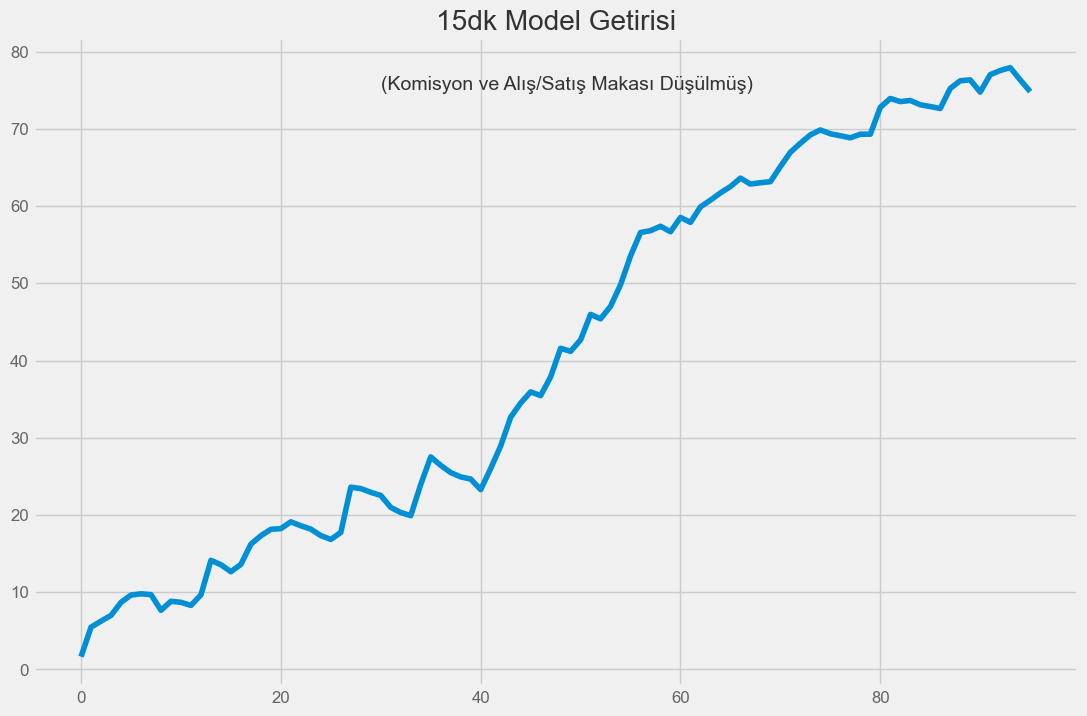

In [930]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.title("15dk Model Getirisi")
plt.text(30,75,"(Komisyon ve Alış/Satış Makası Düşülmüş)")
plt.plot(topkar.reset_index()["Gerçek"])

In [941]:
top_5_rows.sort_values(by="Gerçek",ascending=False)

Gerçek    Tahmin     Hisse  \
Datetime            Datetime                                            
2024-05-23 10:15:00 2024-05-23 10:15:00  6.308464  2.321052  ELITE.IS   
2024-05-21 13:15:00 2024-05-21 13:15:00  5.857982  2.258788  BJKAS.IS   
2024-05-30 10:15:00 2024-05-30 10:15:00  5.413467  4.282034  PRKAB.IS   
2024-05-28 10:15:00 2024-05-28 10:15:00  5.108870  3.672586  MAALT.IS   
2024-05-27 15:15:00 2024-05-27 15:15:00  4.908831  3.518639  ARENA.IS   
...                                           ...       ...       ...   
2024-05-22 10:00:00 2024-05-22 10:00:00 -3.938051  1.031141   ADEL.IS   
2024-05-30 10:15:00 2024-05-30 10:15:00 -4.594260  4.566348  PRZMA.IS   
                    2024-05-30 10:15:00 -5.331336  3.913687  KRVGD.IS   
2024-05-22 10:15:00 2024-05-22 10:15:00 -5.411933  2.333079  DENGE.IS   
2024-05-17 10:00:00 2024-05-17 10:00:00 -5.477861  3.140106  BJKAS.IS   

                                         Tavan Kontrol  
Datetime            Datetime                            
2024-05-23 10:15:00 2024-05-23 10:15:00              0  
2024-05-21 13:15:00 2024-05-21 13:15:00              0  
2024-05-30 10:15:00 2024-05-30 10:15:00              0  
2024-05-28 10:15:00 2024-05-28 10:15:00              0  
2024-05-27 15:15:00 2024-05-27 15:15:00              0  
...                                                ...  
2024-05-22 10:00:00 2024-05-22 10:00:00              0  
2024-05-30 10:15:00 2024-05-30 10:15:00              0  
                    2024-05-30 10:15:00              0  
2024-05-22 10:15:00 2024-05-22 10:15:00              0  
2024-05-17 10:00:00 2024-05-17 10:00:00              0  

[226 rows x 4 columns]

In [943]:
alımlar=top_5_rows[top_5_rows["Hisse"]=="ELITE.IS"].index.droplevel(level=0)
satımlar=top_5_rows[top_5_rows["Hisse"]=="ELITE.IS"].index.droplevel(level=0)+timedelta(minutes=15)

In [948]:
elite=pd.DataFrame(test[test["Hisse"]=="ELITE.IS"]["Adj Close"].loc["2024-05-22":"2024-05-28"])
elite["İndeks"]=range(len(elite))
elite["Date"]=pd.to_datetime(elite.index)
elite["Alım"]=np.where(elite["Date"].isin(alımlar),1,0)
elite["Satım"]=np.where(elite["Date"].isin(satımlar),1,0)
elite=elite.reset_index()

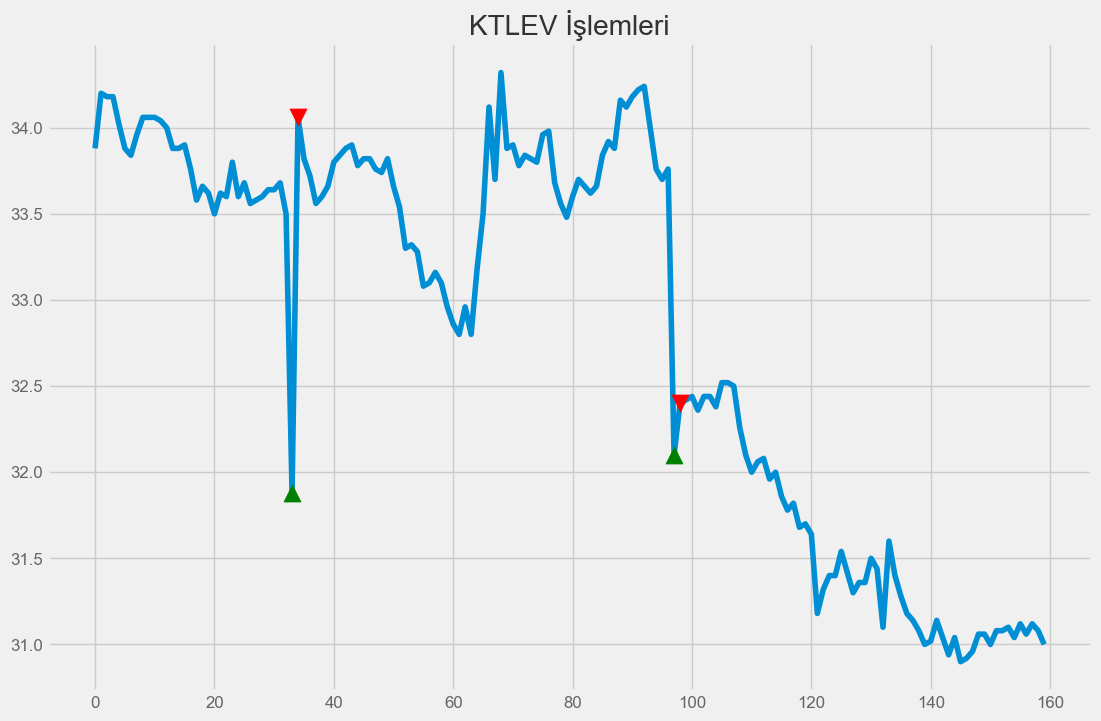

In [949]:

plt.figure(figsize=(12,8))
plt.title("KTLEV İşlemleri")
plt.plot(range(len(test[test["Hisse"]=="ELITE.IS"]["Adj Close"].loc["2024-05-22":"2024-05-28"])),test[test["Hisse"]=="ELITE.IS"]["Adj Close"].loc["2024-05-22":"2024-05-28"])
plt.scatter(x=elite[elite["Alım"]==1].index,y=elite[elite["Alım"]==1]["Adj Close"],marker="^",s=150,color="green",zorder=3)
plt.scatter(x=elite[elite["Satım"]==1].index,y=elite[elite["Satım"]==1]["Adj Close"],marker="v",s=150,color="red",zorder=3)

In [932]:
ktlev=pd.DataFrame(test[test["Hisse"]=="KTLEV.IS"]["Adj Close"].loc["2024-05-16":"2024-05-23"])
ktlev["İndeks"]=range(len(ktlev))
ktlev["Date"]=pd.to_datetime(ktlev.index)
ktlev["Alım"]=np.where(ktlev["Date"].isin(alımlar),1,0)
ktlev["Satım"]=np.where(ktlev["Date"].isin(satımlar),1,0)
ktlev=ktlev.reset_index()

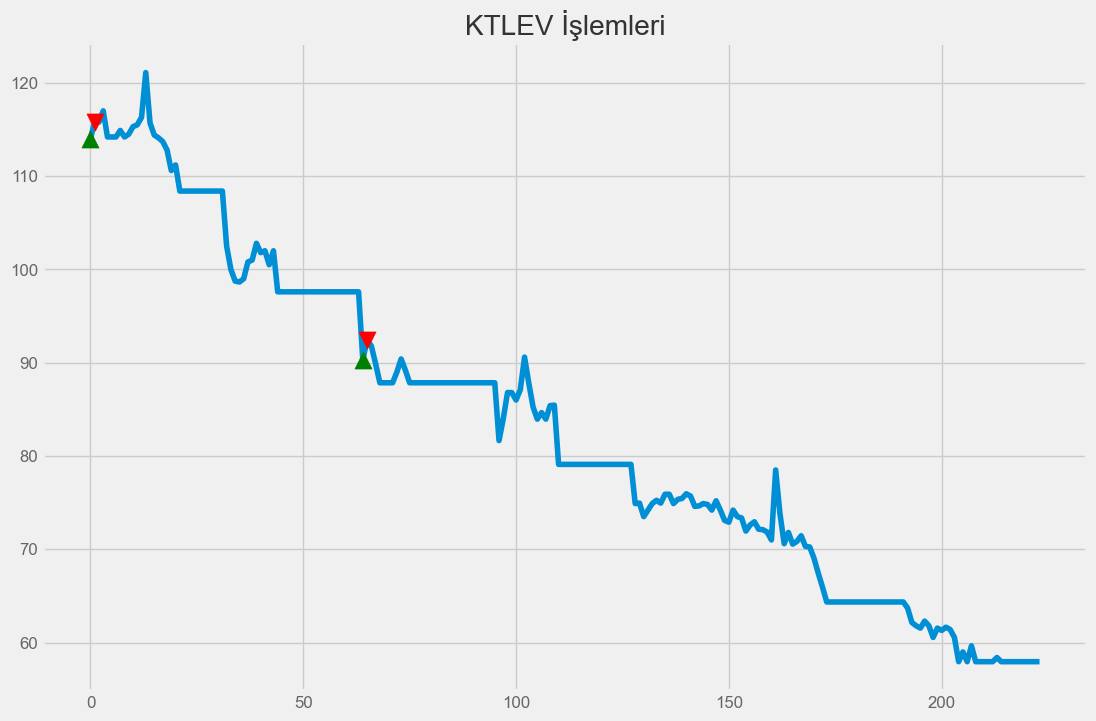

In [933]:

plt.figure(figsize=(12,8))
plt.title("KTLEV İşlemleri")
plt.plot(range(len(test[test["Hisse"]=="KTLEV.IS"]["Adj Close"].loc["2024-05-16":"2024-05-25"])),test[test["Hisse"]=="KTLEV.IS"]["Adj Close"].loc["2024-05-16":"2024-05-25"])
plt.scatter(x=ktlev[ktlev["Alım"]==1].index,y=ktlev[ktlev["Alım"]==1]["Adj Close"],marker="^",s=150,color="green",zorder=3)
plt.scatter(x=ktlev[ktlev["Satım"]==1].index,y=ktlev[ktlev["Satım"]==1]["Adj Close"],marker="v",s=150,color="red",zorder=3)

In [934]:
alımlar=top_5_rows[top_5_rows["Hisse"]=="BJKAS.IS"].index.droplevel(level=0)
satımlar=top_5_rows[top_5_rows["Hisse"]=="BJKAS.IS"].index.droplevel(level=0)+timedelta(minutes=15)

In [935]:
bjkas=pd.DataFrame(test[test["Hisse"]=="BJKAS.IS"]["Adj Close"].loc["2024-05-17":"2024-05-25"])
bjkas["İndeks"]=range(len(bjkas))
bjkas["Date"]=pd.to_datetime(bjkas.index)
bjkas["Alım"]=np.where(bjkas["Date"].isin(alımlar),1,0)
bjkas["Satım"]=np.where(bjkas["Date"].isin(satımlar),1,0)
bjkas=bjkas.reset_index()

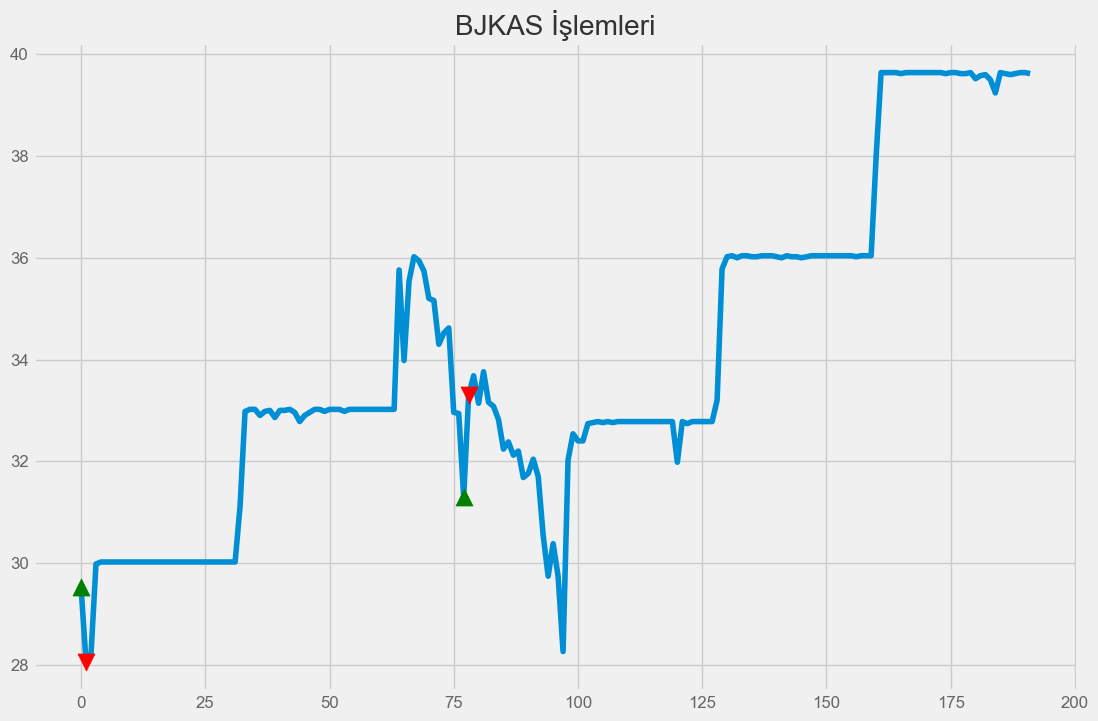

In [936]:
plt.figure(figsize=(12,8))
plt.title("BJKAS İşlemleri")
plt.plot(range(len(test[test["Hisse"]=="BJKAS.IS"]["Adj Close"].loc["2024-05-17":"2024-05-25"])),test[test["Hisse"]=="BJKAS.IS"]["Adj Close"].loc["2024-05-17":"2024-05-25"])
plt.scatter(x=bjkas[bjkas["Alım"]==1].index,y=bjkas[bjkas["Alım"]==1]["Adj Close"],marker="^",s=150,color="green",zorder=3)
plt.scatter(x=bjkas[bjkas["Satım"]==1].index,y=bjkas[bjkas["Satım"]==1]["Adj Close"],marker="v",s=150,color="red",zorder=3)

In [31]:
returns=topkar.diff().dropna()
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns


,Gerçek,Kar
Datetime,,
2024-05-16 10:15:00,0.038278,1
2024-05-16 11:00:00,0.007799,1
2024-05-16 13:15:00,0.007414,1
2024-05-16 13:45:00,0.016916,1
2024-05-16 14:45:00,0.009433,1
...,...,...
2024-05-31 14:00:00,0.022525,1
2024-05-31 14:15:00,0.005416,1
2024-05-31 15:15:00,0.003794,1


In [36]:
endeks=yf.download(tickers="XU100.IS",start="2024-04-04",interval="15m")
endeks["Getiri"]=(endeks["Adj Close"]/endeks["Adj Close"].shift(1))-1


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ------------
Start Period               2024-05-17   2024-05-17
End Period                 2024-05-31   2024-05-31
Risk-Free Rate             0.0%         0.0%
Time in Market             12.0%        100.0%

Cumulative Return          2.44%        93.22%
CAGR﹪                     54.23%       14096849.17%

Sharpe                     0.98         7.72
Prob. Sharpe Ratio         72.65%       100.0%
Smart Sharpe               0.79         6.26
Sortino                    1.72         24.95
Smart Sortino              1.4          20.24
Sortino/√2                 1.22         17.64
Smart Sortino/√2           0.99         14.31
Omega                      3.93         3.93

Max Drawdown               -4.04%       -4.17%
Longest DD Days            8            3
Volatility (ann.)          7.41%        25.21%
R^2                        0.0          0.0
Information Ratio          0.45         0.45
Calmar     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-05-22,2024-05-23,2024-05-23,1,-4.167906,-2.837060
2,2024-05-21,2024-05-22,2024-05-22,1,-3.633330,-3.243155
3,2024-05-31,2024-05-31,2024-05-31,1,-3.079850,-1.581908
4,2024-05-21,2024-05-21,2024-05-21,1,-2.257253,-1.778390
5,2024-05-31,2024-05-31,2024-05-31,1,-1.583844,NaN


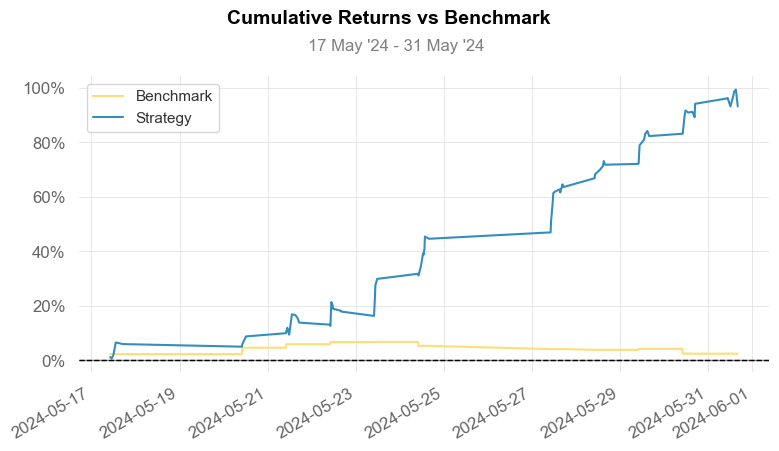

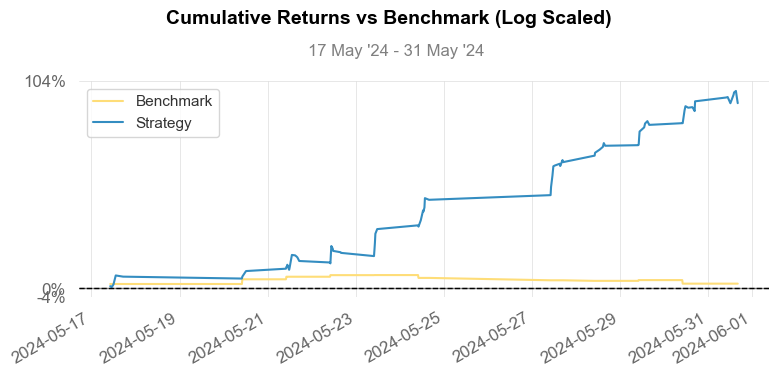

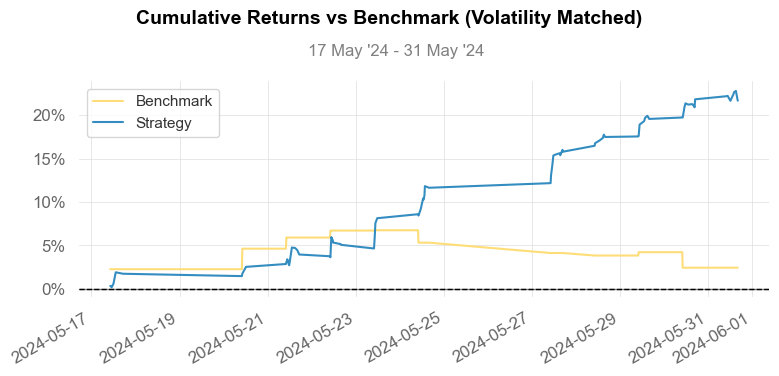

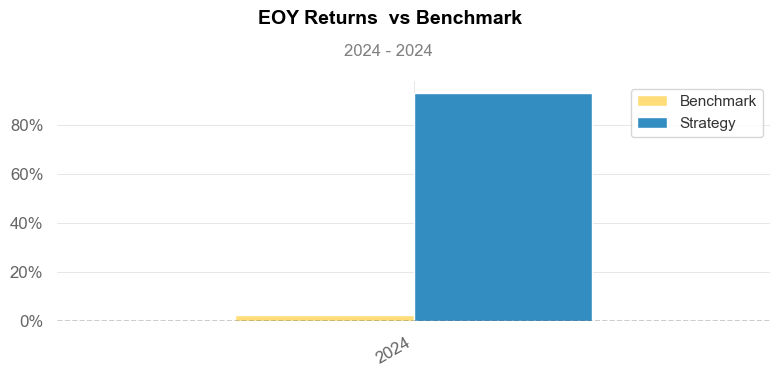

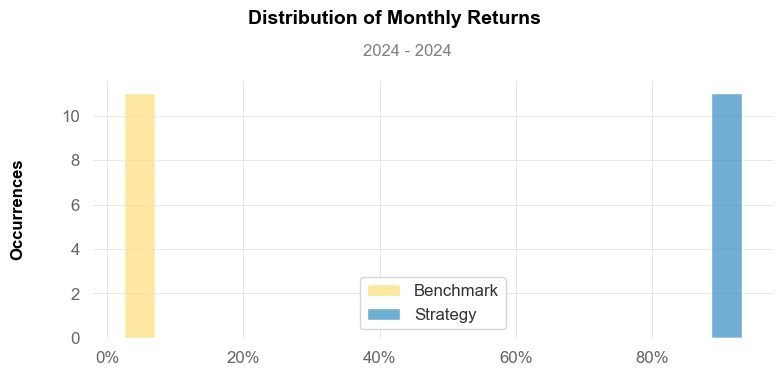

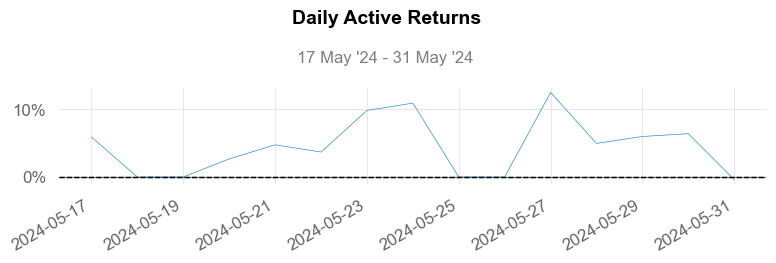

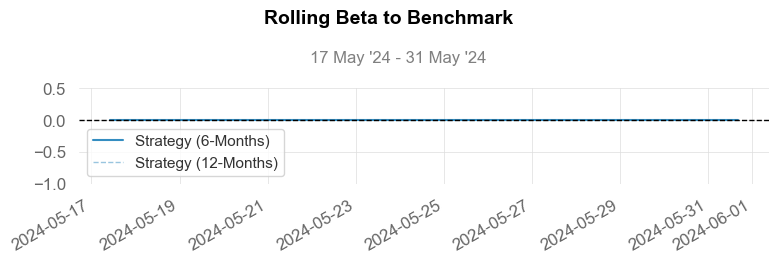

IndexError: index 0 is out of bounds for axis 0 with size 0

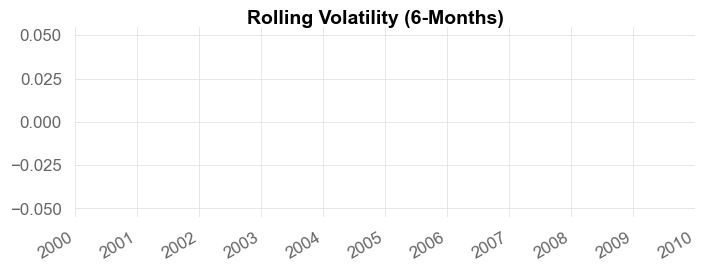

In [39]:
qs.reports.full(returns=returns["Gerçek"],benchmark=endeks["Getiri"])